In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math
import numpy as np
import os
import Data_and_analysis as DA

In [3]:
Div = 'E0'

df = DA.get_league_data(Div)

Checking/Downloading data for E0...
Successfully loaded: Data/E0/E0_0001.csv
Successfully loaded: Data/E0/E0_0102.csv
Successfully loaded: Data/E0/E0_0203.csv
Successfully loaded: Data/E0/E0_0304.csv
Successfully loaded: Data/E0/E0_0405.csv
Successfully loaded: Data/E0/E0_0506.csv
Successfully loaded: Data/E0/E0_0607.csv
Successfully loaded: Data/E0/E0_0708.csv
Successfully loaded: Data/E0/E0_0809.csv
Successfully loaded: Data/E0/E0_0910.csv
Successfully loaded: Data/E0/E0_1011.csv
Successfully loaded: Data/E0/E0_1112.csv
Successfully loaded: Data/E0/E0_1213.csv
Successfully loaded: Data/E0/E0_1314.csv
Successfully loaded: Data/E0/E0_1415.csv
Successfully loaded: Data/E0/E0_1516.csv
Successfully loaded: Data/E0/E0_1617.csv
Successfully loaded: Data/E0/E0_1718.csv
Successfully loaded: Data/E0/E0_1819.csv
Successfully loaded: Data/E0/E0_1920.csv
Successfully loaded: Data/E0/E0_2021.csv
Successfully loaded: Data/E0/E0_2122.csv
Successfully loaded: Data/E0/E0_2223.csv
Successfully loaded: 

In [5]:
train_df, test_df = DA.train_test_split(df)

Removing teams from test set (not in training): {'Luton', 'Brentford'}


In [8]:
from Stats_Models import Mod_Poisson_Odd as MPO
my_modified_poisson_odd = MPO.Mod_Poisson_Odd()
my_modified_poisson_odd.initialize_model(train_df)

my_modified_poisson_odd.initialize_team_stat(test_df)
my_modified_poisson_odd.load_alpha_beta()

In [6]:
my_modified_poisson_odd.predict_probabilities(test_df)

In [10]:
def analyze_betting_opportunities(df, bet_against=['PS', 'B365'], ev_threshold=1.0):
    # Create all possible combinations of bookmakers and outcomes once
    combinations = [(book, outcome) for book in bet_against for outcome in ['H', 'A', 'D']]
    
    bet_history = []
    
    # Vectorized operation using apply
    def process_row(row):
        for book, outcome in combinations:
            odd = row[book + outcome]
            prob = row[outcome + '_probability']
            if odd * prob > ev_threshold:
                bet_history.append({
                    'book': book,
                    'Date': row['Date'],
                    'Side': outcome,
                    'Odd': odd,
                    'Probability': prob,
                    'match outcome': row['FTR']
                })
    
    # Apply the function to each row
    df.apply(process_row, axis=1)
    
    return bet_history

In [12]:
my_modified_poisson_odd.predict_probabilities(train_df)
bet_history_train = analyze_betting_opportunities(train_df,ev_threshold=1.00)

In [13]:
def evaluate_bets(bet_history, initial_bank=1000, kelly_factor=0.05):
    if len(bet_history) == 0:
        print('No trade found')
        return 
    bank = initial_bank
    results = []
    
    for bet in bet_history:
        # Kelly fraction calculation
        b = bet['Odd'] - 1
        p = bet['Probability']
        q = 1 - p
        kelly = max(0, (b*p - q)/b * kelly_factor)  # Half Kelly, no negative bets
        
        # Calculate bet details
        bet_size = kelly * bank
        won = bet['Side'] == bet['match outcome']
        profit = bet_size * (bet['Odd'] - 1) if won else -bet_size
        bank += profit
        
        # Store result
        results.append({
            'date': bet['Date'],
            'bookmaker': bet['book'],
            'match_outcome': bet['match outcome'],
            'bet_side': bet['Side'],
            'odds': bet['Odd'],
            'probability': bet['Probability'],
            'bet_size': bet_size,
            'won': won,
            'profit': profit,
            'bank': bank
        })
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    # Calculate summary statistics
    total_bets = len(results)
    winning_bets = results_df['won'].sum()
    win_rate = winning_bets/total_bets if total_bets > 0 else 0
    roi = (bank - initial_bank)/initial_bank * 100
    
    summary = {
        'total_bets': total_bets,
        'winning_bets': winning_bets,
        'win_rate': win_rate,
        'final_bank': bank,
        'roi': roi
    }
    
    # Add cumulative statistics to DataFrame
    results_df['cumulative_profit'] = results_df['profit'].cumsum()
    results_df['cumulative_win_rate'] = results_df['won'].cumsum() / (results_df.index + 1)
    results_df['cumulative_roi'] = (results_df['bank'] - initial_bank) / initial_bank * 100
    
    return results_df, summary

In [14]:
results_df_train, summary_train = evaluate_bets(bet_history_train)

# Basic analysis examples
print("\nProfitability by bookmaker(Train):")
print(results_df_train.groupby('bookmaker')['profit'].agg(['count', 'sum', 'mean']))

print("\nWin rate by bet side(Train):")
print(results_df_train.groupby('bet_side')['won'].agg(['count', 'mean']))


Profitability by bookmaker(Train):
           count        sum      mean
bookmaker                            
B365        1592  22.811741  0.014329
PS          2072  94.038551  0.045385

Win rate by bet side(Train):
          count      mean
bet_side                 
A           875  0.579429
D           447  0.389262
H          2342  0.603330


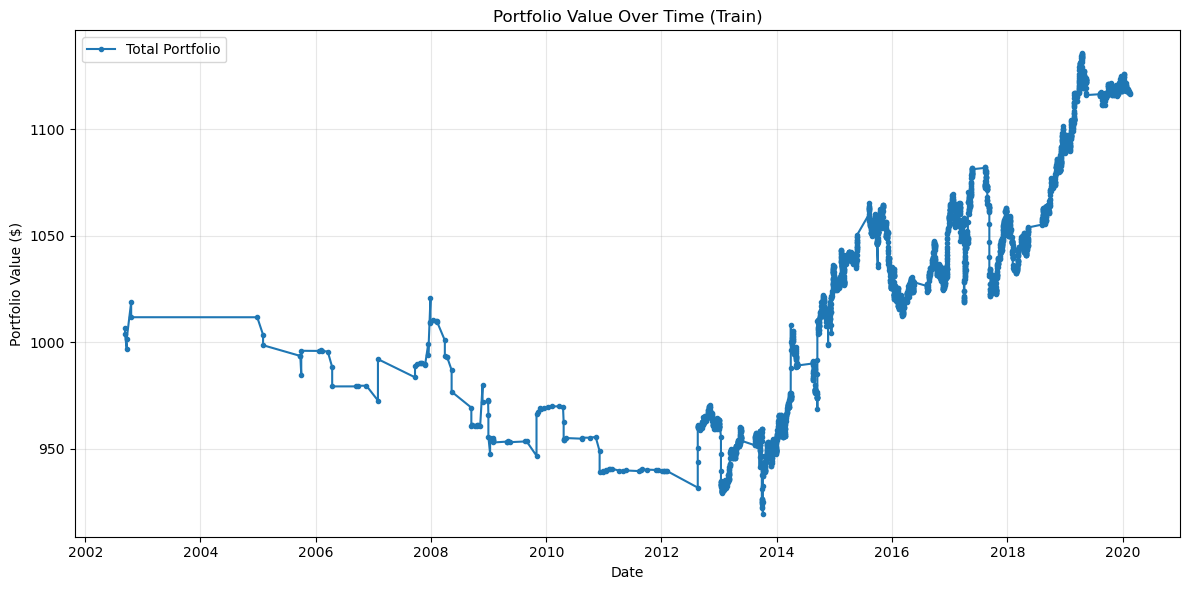

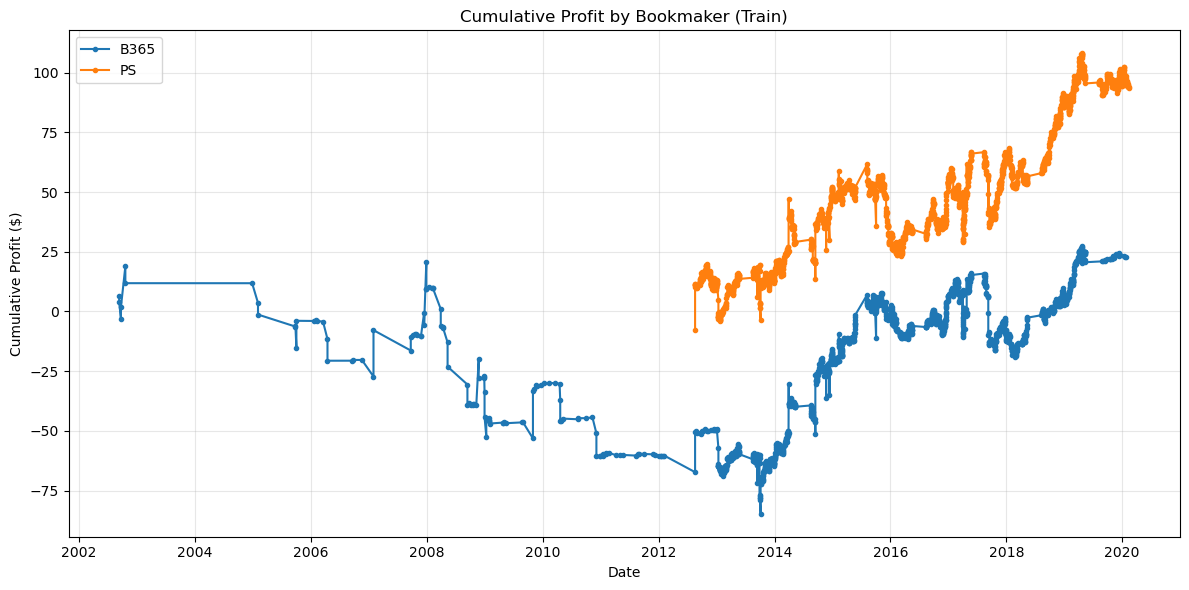

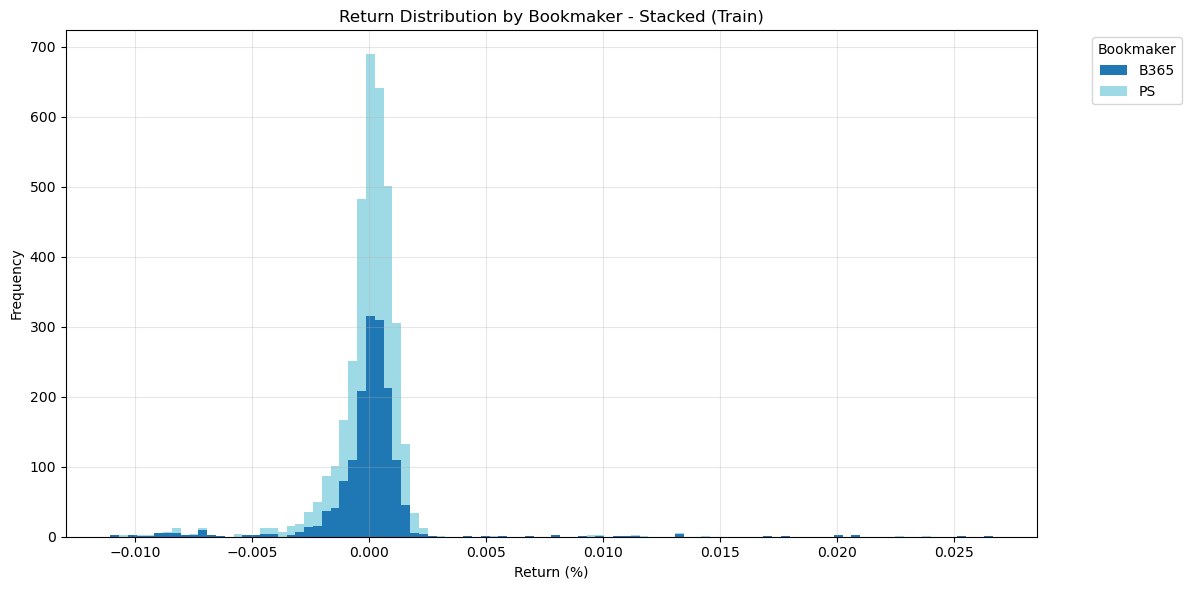

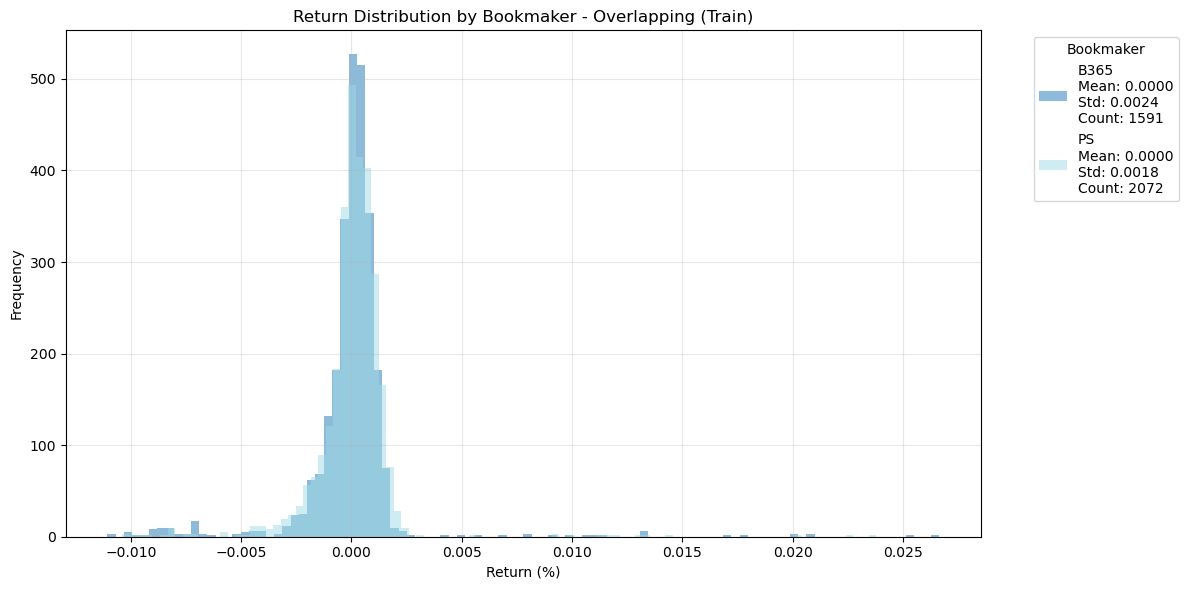

In [15]:
def analyze_betting_performance(results_df, dataset_label='Train', figsize=(12, 6), bins=100):

    # 1. Portfolio Value Over Time
    plt.figure(figsize=figsize)
    plt.plot(
        pd.to_datetime(results_df['date']), 
        results_df['bank'], 
        label='Total Portfolio',
        marker='o',
        markersize=3
    )
    plt.title(f'Portfolio Value Over Time ({dataset_label})')
    plt.ylabel('Portfolio Value ($)')
    plt.xlabel('Date')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # 2. Cumulative Profit by Bookmaker
    plt.figure(figsize=figsize)
    bookmaker_datas = []
    for bookmaker in results_df['bookmaker'].unique():
        bookmaker_data = results_df[results_df['bookmaker'] == bookmaker]
        bookmaker_datas.append(bookmaker_data)
        plt.plot(
            pd.to_datetime(bookmaker_data['date']), 
            bookmaker_data['profit'].cumsum(), 
            label=bookmaker,
            marker='o',
            markersize=3
        )
    plt.title(f'Cumulative Profit by Bookmaker ({dataset_label})')
    plt.ylabel('Cumulative Profit ($)')
    plt.xlabel('Date')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # 3. Stacked Return Distribution
    returns = results_df['bank'].pct_change().dropna()
    returns_df = pd.DataFrame({
        'return': returns,
        'bookmaker': results_df['bookmaker'].iloc[1:]
    })
    
    plt.figure(figsize=figsize)
    bookmakers = returns_df['bookmaker'].unique()
    colors = plt.cm.tab20(np.linspace(0, 1, len(bookmakers)))
    
    plt.hist([returns_df[returns_df['bookmaker'] == bookie]['return'] for bookie in bookmakers],
             bins=bins,
             stacked=True,
             label=bookmakers,
             color=colors)
    
    plt.title(f'Return Distribution by Bookmaker - Stacked ({dataset_label})')
    plt.xlabel('Return (%)')
    plt.ylabel('Frequency')
    plt.legend(title='Bookmaker', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # 4. Overlapping Return Distributions
    plt.figure(figsize=figsize)
    
    for idx, bookie in enumerate(bookmakers):
        bookie_returns = returns_df[returns_df['bookmaker'] == bookie]['return']
        plt.hist(bookie_returns, 
                bins=bins, 
                alpha=0.5,  # Lower transparency for overlapping
                label=f'{bookie}\n'
                      f'Mean: {bookie_returns.mean():.4f}\n'
                      f'Std: {bookie_returns.std():.4f}\n'
                      f'Count: {len(bookie_returns)}',
                color=colors[idx],
                density=True)
    
    plt.title(f'Return Distribution by Bookmaker - Overlapping ({dataset_label})')
    plt.xlabel('Return (%)')
    plt.ylabel('Frequency')
    plt.legend(title='Bookmaker', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Return summary statistics
    return {
        'total_profit': results_df['profit'].sum(),
        'profit_by_bookmaker': {bookie: results_df[results_df['bookmaker'] == bookie]['profit'].sum() 
                               for bookie in bookmakers},
        'returns_summary': returns.describe(),
        'returns_by_bookmaker': {bookie: returns_df[returns_df['bookmaker'] == bookie]['return'].describe() 
                                for bookie in bookmakers}
    }

stats_train = analyze_betting_performance(results_df_train, 'Train')

In [16]:
def calculate_betting_metrics(results_df, initial_bank=1000):
    """
    Calculate improved betting performance metrics
    """
    returns = results_df['bank'].pct_change().dropna()
    
    # Basic statistics
    win_rate = results_df['won'].mean()
    p = win_rate
    q = 1 - p
    avg_win = results_df[results_df['won']]['profit'].mean()
    avg_loss = abs(results_df[~results_df['won']]['profit'].mean())
    R = avg_win / avg_loss if avg_loss != 0 else np.inf
    
    # 1. Information Ratio
    # Using excess returns over break-even rate instead of win rate
    excess_returns = returns - (results_df['probability'].mean())
    info_ratio = np.sqrt(252) * excess_returns.mean() / excess_returns.std() if excess_returns.std() != 0 else 0
    
    # 2. Calmar Ratio
    cumulative_returns = (results_df['bank'] / initial_bank) - 1
    running_max = cumulative_returns.cummax()
    drawdowns = running_max - cumulative_returns
    max_drawdown = drawdowns.max()
    total_return = (results_df['bank'].iloc[-1]/initial_bank - 1)
    calmar = total_return / max_drawdown if max_drawdown != 0 else np.inf
    
    # 3. Risk of Ruin (based on expected value)
    expected_value = p*R - q
    
    if expected_value > 0:  # Positive expectation game
        critical_p = 1/(R + 1)
        if p > critical_p:
            risk_of_ruin = ((q/p)**(initial_bank/avg_loss))
        else:
            risk_of_ruin = 1.0
    else:
        risk_of_ruin = 1.0
    
    # 4. Kelly Edge (improved with true odds comparison)
    implied_probs = 1/results_df['odds']
    actual_probs = results_df['probability']
    edges = actual_probs - implied_probs
    kelly_edge = edges.mean()
    
    # 5. Profit Factor (unchanged but added consistency check)
    gross_wins = results_df[results_df['profit'] > 0]['profit'].sum()
    gross_losses = abs(results_df[results_df['profit'] < 0]['profit'].sum())
    profit_factor = gross_wins / gross_losses if gross_losses != 0 else np.inf
    
    # Additional useful metrics
    sharpe_equiv = np.sqrt(252) * returns.mean() / returns.std() if returns.std() != 0 else 0
    kelly_fraction = (p*R - q)/R if R != 0 else 0
    
    return {
        'information_ratio': info_ratio,
        'calmar_ratio': calmar,
        'risk_of_ruin': risk_of_ruin,
        'kelly_edge': kelly_edge,
        'profit_factor': profit_factor,
        'max_drawdown': max_drawdown,
        'win_rate': win_rate,
        'sharpe_equivalent': sharpe_equiv,
        'kelly_fraction': kelly_fraction,
        'avg_win_loss_ratio': R,
        'expected_value': expected_value
    }

metrics_train = calculate_betting_metrics(results_df_train)
for metric, value in metrics_train.items():
    print(f'{metric}: {value:.3f}')

information_ratio: -4288.274
calmar_ratio: 1.155
risk_of_ruin: 0.000
kelly_edge: 0.010
profit_factor: 1.064
max_drawdown: 0.101
win_rate: 0.572
sharpe_equivalent: 0.233
kelly_fraction: 0.035
avg_win_loss_ratio: 0.798
expected_value: 0.028


In [30]:
my_modified_poisson_odd.predict_probabilities(test_df)
bet_history_test = analyze_betting_opportunities(test_df,ev_threshold=1.00)

In [32]:
results_df_test, summary_test = evaluate_bets(bet_history_test)

# Basic analysis examples
print("\nProfitability by bookmaker(Test):")
print(results_df_test.groupby('bookmaker')['profit'].agg(['count', 'sum', 'mean']))

print("\nWin rate by bet side(Test):")
print(results_df_test.groupby('bet_side')['won'].agg(['count', 'mean']))


Profitability by bookmaker(Test):
           count        sum      mean
bookmaker                            
B365         176   0.788590  0.004481
PS           962  35.951809  0.037372

Win rate by bet side(Test):
          count      mean
bet_side                 
A           345  0.582609
D            33  0.303030
H           760  0.626316


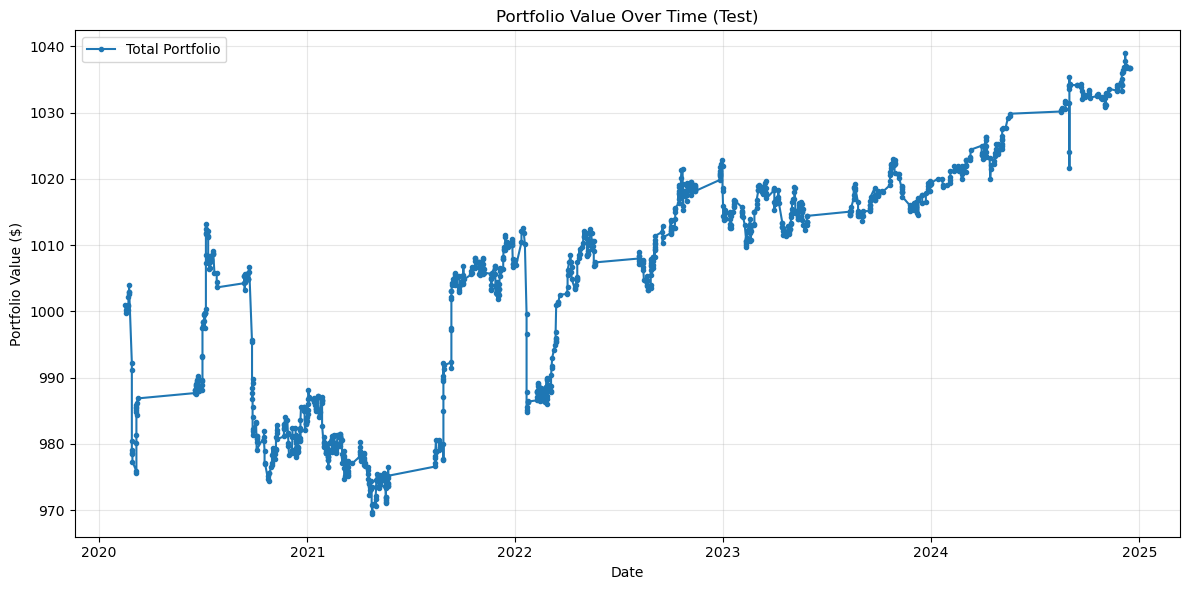

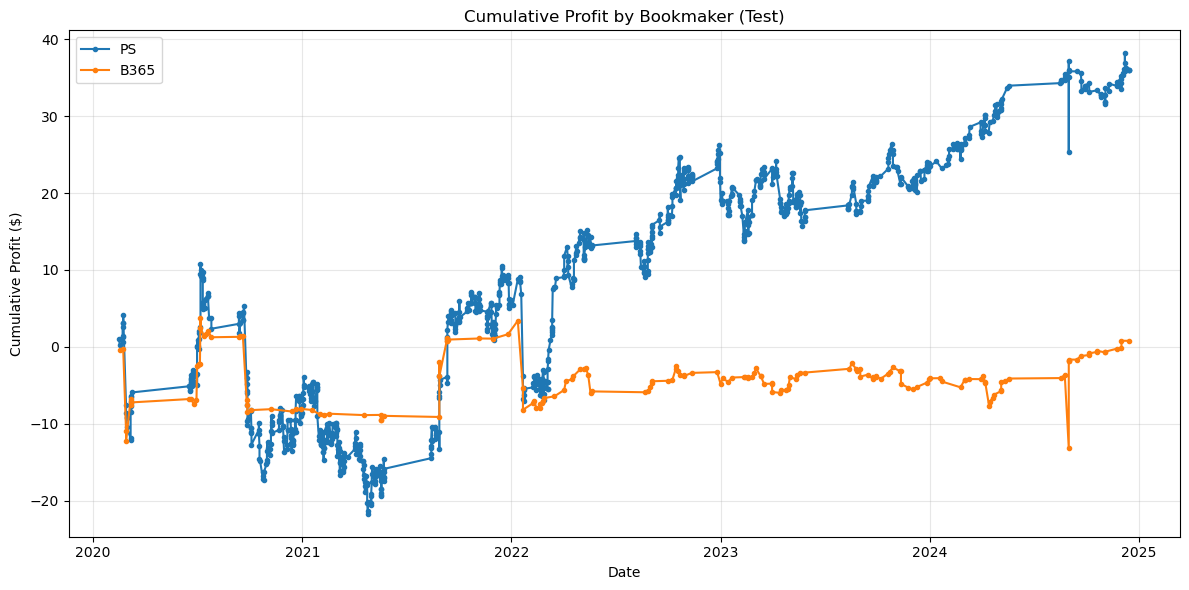

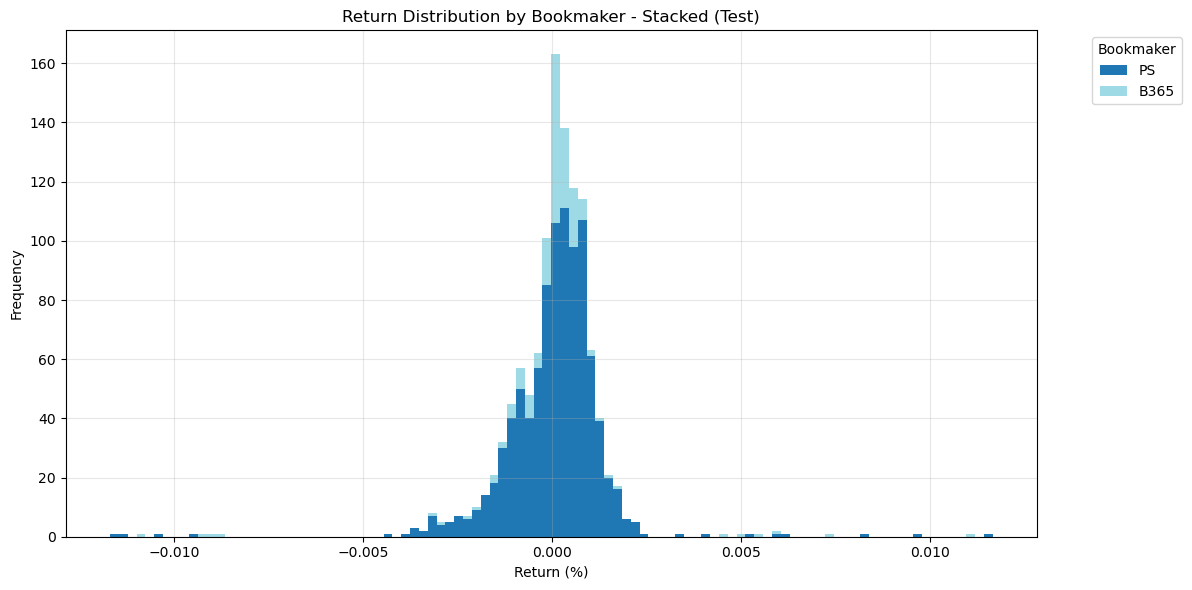

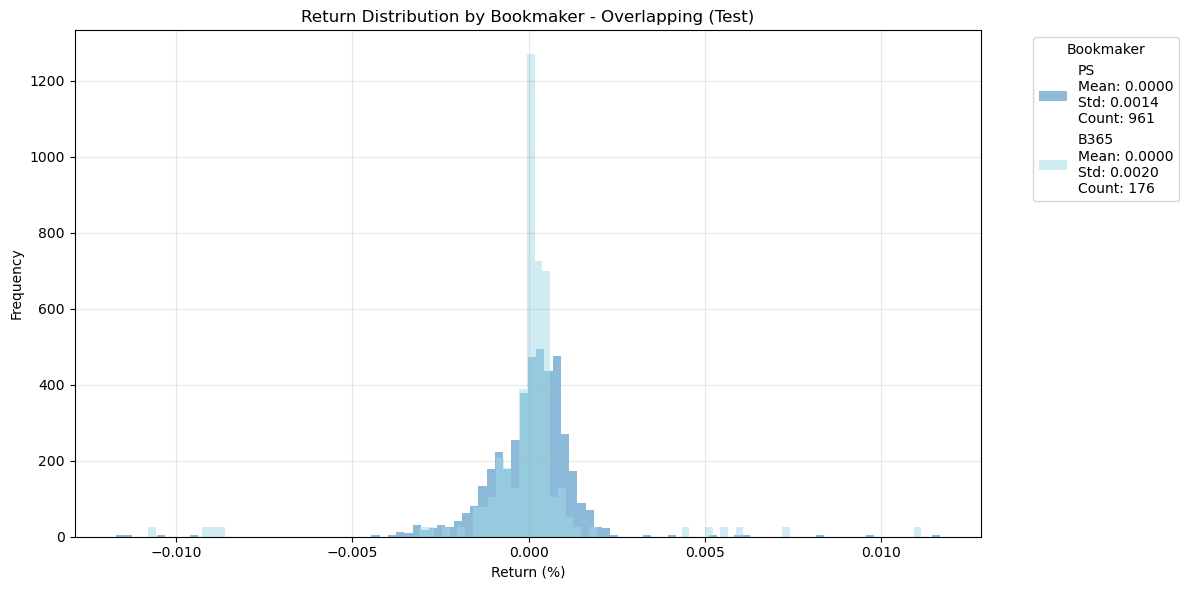

In [34]:
stats_test = analyze_betting_performance(results_df_test, 'Test')

In [35]:
metrics_test = calculate_betting_metrics(results_df_test)
for metric, value in metrics_test.items():
    print(f'{metric}: {value:.3f}')

information_ratio: -6125.095
calmar_ratio: 0.839
risk_of_ruin: 0.000
kelly_edge: 0.009
profit_factor: 1.077
max_drawdown: 0.044
win_rate: 0.604
sharpe_equivalent: 0.336
kelly_fraction: 0.043
avg_win_loss_ratio: 0.707
expected_value: 0.031
